In [1]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from catboost import CatBoostClassifier, Pool
import datetime
import warnings

# Suppress PerformanceWarning
warnings.filterwarnings("ignore")

## Load data

Prior to loading the data, we identify and categorize columns with string data types in the dataset. Additionally, it selects columns from the 'V' category, focusing on those that exhibit meaningful relationships with the target variable as revealed through correlation-based exploratory data analysis (EDA). By doing so, the code aims to streamline the dataset to include only the most relevant 'V' columns, optimizing computational efficiency and model performance during subsequent analysis and modeling phases.

In [2]:
# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

In [3]:
%%time
# LOAD TRAIN
X_train = pd.read_csv('./train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv('./train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = pd.read_csv('./test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv('./test_identity.csv',index_col='TransactionID', dtype=dtypes)
fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)
# TARGET
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()
# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 213) test shape (506691, 213)
CPU times: user 8.83 s, sys: 964 ms, total: 9.79 s
Wall time: 10 s


## Normalizing and converting D columns

After looking at the dataset, we realise that the 'D Columns' represent time intervals relative to a specific past reference point. Our objective is to remove time dependence and convert these 'D Columns' into values that correspond to moments in the past rather than future time intervals. This adjustment ensures that the 'D Columns' no longer exhibit an increasing trend over time because we have normalized it against the effects of time. We achieve this transformation using the formula `D15n = Transaction_Day - D15`, where 'Transaction_Day' is calculated as 'TransactionDT' divided by the number of seconds in a day (24 hours * 60 minutes * 60 seconds). Subsequently, we invert the result by multiplying it by -1.

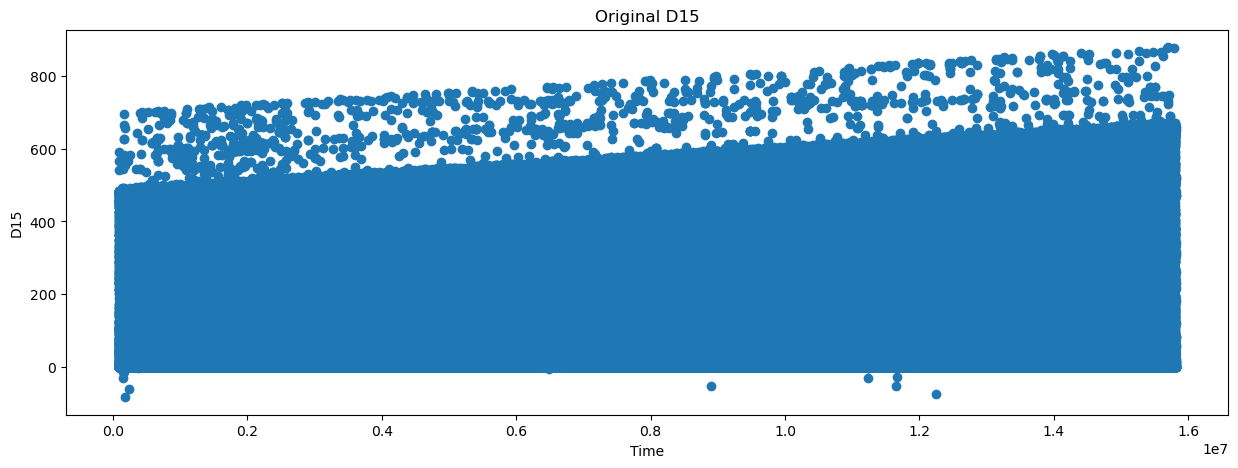

In [4]:
# PLOT ORIGINAL D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

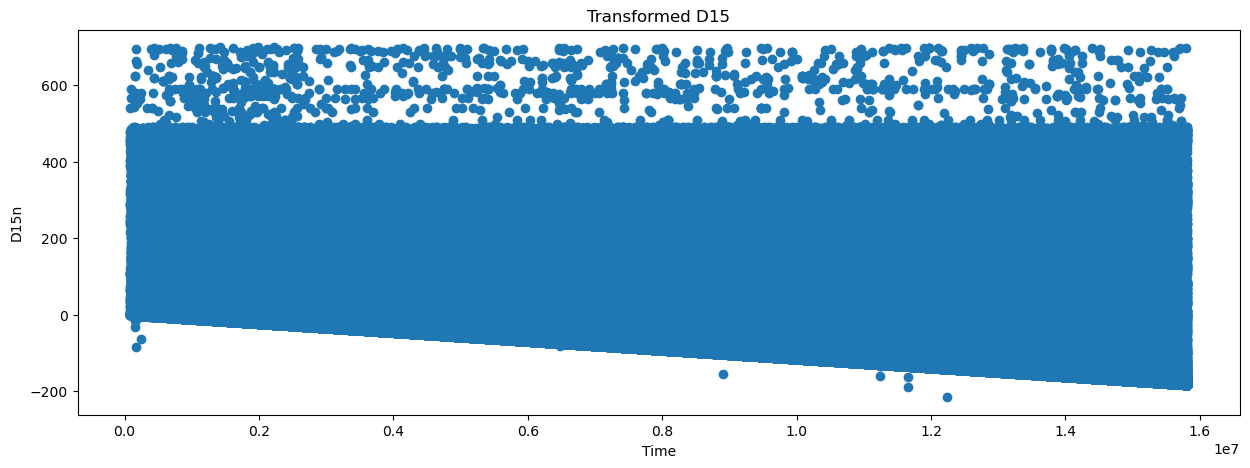

In [5]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: 
        continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 
    
# PLOT TRANSFORMED D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Transformed D15')
plt.xlabel('Time')
plt.ylabel('D15n')
plt.show()

## Dataset cleaning and preprocessing

Our next step involves the transformation of categorical variables to integers through encoding, the normalization of numeric columns, and addressing any missing data. Given the substantial size of the dataset, we also prioritize memory optimization by ensuring the usage of compatible data types wherever possible. This multi-faceted data preprocessing process aims to enhance the dataset's suitability for analysis and modeling, considering both its size and the type of data it contains.

In [6]:
%%time
# LABEL ENCODE AND MEMORY REDUCE
for i, f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (str(X_train[f].dtype) == 'category') or (X_train[f].dtype == 'object'): 
        df_comb = pd.concat([X_train[f], X_test[f]], axis=0)
        df_comb, _ = df_comb.factorize(sort=True)
        if df_comb.max() > 32000:
            print(f, 'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt', 'TransactionDT']:
        mn = np.min((X_train[f].min(), X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1, inplace=True)
        X_test[f].fillna(-1, inplace=True)

CPU times: user 1.25 s, sys: 298 ms, total: 1.54 s
Wall time: 1.67 s


## Encoding functions

To address categorical variables, we must identify and consider all categorical variables that are present in both the test and train sets. This comprehensive approach ensures that we encode all relevant categorical variables consistently across the entire dataset.

1) `encode_FE` performs frequency encoding after in combines the train and test set. This allows us to see whether the column values are rare or common. For example, we can use this to check which credit cards are used infrequently.

2) `encode_LE` performs label encoding on the categorical features and converts them into integers. We factorize to reduce memory and turn NAN into -1.

3) `encode_AG` creates aggregated features such as the aggregated mean and std dev. This allows for the model to tell if a row has abnormal values compared to the mean value.

4) `encode_CB` combines two columns together into one column.

5) `encode_AG2` creates more aggregated features where it counts how many unique values of one feature within a group.

In [7]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')
        
# GROUP AGGREGATION MEAN AND STD
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    df1 = df1.copy()
    df2 = df2.copy()
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')
    train_df = train_df.copy()
    test_df = test_df.copy()

# Feature engineering

In this procedure, we brainstorm potential methods to create new features. Subsequently, we assess each newly generated feature's impact on the Area Under the Curve (AUC) metric. If the addition of a feature leads to an increase in AUC, we retain that feature; otherwise, we eliminate it from consideration. This iterative process helps us identify and incorporate features that enhance model performance while disregarding those that do not contribute positively. The below features are the features that we have thought of that increases the AUC score.

In [8]:
%%time
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

cents, addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , CPU times: user 2.88 s, sys: 1.56 s, total: 4.44 s
Wall time: 5.01 s


# Feature selection

Above, we added 28 additional features, bringing the total number of columns to 242, including the index. With this substantial number of features, our goal is to identify the pertinent ones that significantly impact our model's performance. Our chosen evaluation metric is AUC. Therefore, we need to systematically evaluate each feature to ensure that it contributes positively to the model.

We will be using data from the first 30 days as train data to train the model, and use data from the last 30 days as test data to test the model. Specifically, we want to confirm that each feature yields an AUC score >0.5 to be considered valuable, if not the feature is not useful as it is worse than random guessing which yields an AUC score of 0.5. Features failing to meet this criterion are considered non-contributory and will be excluded from further consideration.

In [9]:
# Define the start and end timestamps for the first and last months, assuming 30 days in a month
start_timestamp_first_month = X_train['TransactionDT'].min()
end_timestamp_first_month = start_timestamp_first_month + (30 * 24 * 60 * 60)  

start_timestamp_last_month = X_train['TransactionDT'].max() - (30 * 24 * 60 * 60)  
end_timestamp_last_month = X_train['TransactionDT'].max()

# Select rows corresponding to the first month
X_first_month = X_train[(X_train['TransactionDT'] >= start_timestamp_first_month) &
                         (X_train['TransactionDT'] < end_timestamp_first_month)]

# Select rows corresponding to the last month
X_last_month = X_train[(X_train['TransactionDT'] >= start_timestamp_last_month) &
                        (X_train['TransactionDT'] <= end_timestamp_last_month)]

# Extract the indices of rows in X_train that belong to the first month
indices_first_month = (X_train['TransactionDT'] >= start_timestamp_first_month) & (X_train['TransactionDT'] < end_timestamp_first_month)

# Extract the indices of rows in X_train that belong to the last month
indices_last_month = (X_train['TransactionDT'] >= start_timestamp_last_month) & (X_train['TransactionDT'] <= end_timestamp_last_month)

# Use the indices to extract the corresponding y_train entries
y_first_month = y_train[indices_first_month]
y_last_month = y_train[indices_last_month]

In [10]:
%%time
# Create an empty list to store the selected features
selected_features = []

# Define the evaluation threshold (AUC > 0.5)
threshold = 0.5

# Create a tqdm progress bar for the loop
for feature in tqdm(X_train.columns, desc="Processing Features"):
    
    # Train a logistic regression model using only the current feature
    #model = xgb.XGBClassifier()
    model = lgb.LGBMClassifier()
    model.fit(X_first_month[[feature]], y_first_month)
    
    # Predict on the last month of the training data
    y_pred = model.predict_proba(X_last_month[[feature]])[:, 1]
    
    # Calculate AUC for the validation set
    auc = roc_auc_score(y_last_month, y_pred)
    
    # Check if AUC is above the threshold
    if auc > threshold:
        selected_features.append(feature)

Processing Features: 100%|████████████████████| 241/241 [01:15<00:00,  3.21it/s]

CPU times: user 7min 6s, sys: 1min 31s, total: 8min 37s
Wall time: 1min 15s


In [11]:
print('Following',242 - len(selected_features),'features removed:')
print(np.array(set(X_train.columns) - set(selected_features)))
print('#'*70)
print('Following',len(selected_features),'features selected:')
print(np.array(selected_features))

Following 37 features removed:
{'V68', 'V310', 'V107', 'V65', 'V26', 'V297', 'V89', 'id_22', 'V88', 'V142', 'V56', 'V305', 'V160', 'id_26', 'V67', 'id_34', 'V314', 'id_08', 'V309', 'id_38', 'id_31', 'V14', 'V27', 'V285', 'id_32', 'V138', 'id_21', 'TransactionDT', 'V162', 'V20', 'V289', 'card4', 'V62', 'id_14', 'id_07', 'V286'}
######################################################################
Following 205 features selected:
['TransactionAmt' 'ProductCD' 'card1' 'card2' 'card3' 'card5' 'card6'
 'addr1' 'addr2' 'dist1' 'dist2' 'P_emaildomain' 'R_emaildomain' 'C1' 'C2'
 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'C9' 'C10' 'C11' 'C12' 'C13' 'C14' 'D1'
 'D2' 'D3' 'D4' 'D5' 'D6' 'D7' 'D8' 'D9' 'D10' 'D11' 'D12' 'D13' 'D14'
 'D15' 'M1' 'M2' 'M3' 'M4' 'M5' 'M6' 'M7' 'M8' 'M9' 'V1' 'V3' 'V4' 'V6'
 'V8' 'V11' 'V13' 'V17' 'V23' 'V30' 'V36' 'V37' 'V40' 'V41' 'V44' 'V47'
 'V48' 'V54' 'V59' 'V70' 'V76' 'V78' 'V80' 'V82' 'V86' 'V91' 'V108' 'V111'
 'V115' 'V117' 'V120' 'V121' 'V123' 'V124' 'V127' 'V129' 'V13

## Local validation 

We conduct a train-test split, where our model is trained on the first 75% of the dataset and assessed on the remaining 25%. In our local validation, the model achieved an AUC of 0.9304.

In [12]:
# train split local validation
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

In [13]:
%%time

# lgboost
print("LGBoost version:", lgb.__version__)

clf = lgb.LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=5000,
    max_depth=12,
    learning_rate=0.02,
    subsample=0.8,
    colsample_bytree=0.4,
    metric='auc',
    n_jobs=8,
)

# Create the log_evaluation callback
callbacks = [
    lgb.early_stopping(100),
    lgb.callback.log_evaluation(period=100)  # Add this callback for verbosity
]

# Fit the model with callbacks
h = clf.fit(
    X_train.loc[idxT, selected_features],
    y_train[idxT],
    eval_set=[(X_train.loc[idxV, selected_features], y_train[idxV])],
    callbacks=callbacks  # Use the callbacks argument for controlling verbosity
)

# Find the optimal iteration
optimal_iteration = clf.best_iteration_
print(f"Optimal iteration: {optimal_iteration}")

# xgboost too slow
# %%time
# print("XGBoost version:", xgb.__version__)

# clf = xgb.XGBClassifier( 
#     n_estimators=500, #2000
#     max_depth=6, # 12
#     learning_rate=0.1, #0.02
#     subsample=0.8,
#     colsample_bytree=0.4, 
#     missing=-1, 
#     eval_metric='auc',
#     early_stopping_rounds=50,
#     # USE CPU
#     nthread=8,
#     tree_method='hist' 
#     # USE GPU
#     #n_jobs=-1,
#     #tree_method='gpu_hist'
# )

# print('XGM model created')

# h = clf.fit(X_train.loc[idxT,selected_features], y_train[idxT], 
#     eval_set=[(X_train.loc[idxV,selected_features],y_train[idxV])],
#     verbose=10)

LGBoost version: 3.3.5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.874218
[200]	valid_0's auc: 0.89624
[300]	valid_0's auc: 0.906282
[400]	valid_0's auc: 0.911721
[500]	valid_0's auc: 0.915081
[600]	valid_0's auc: 0.917738
[700]	valid_0's auc: 0.919365
[800]	valid_0's auc: 0.921322
[900]	valid_0's auc: 0.923405
[1000]	valid_0's auc: 0.924795
[1100]	valid_0's auc: 0.92529
[1200]	valid_0's auc: 0.925801
[1300]	valid_0's auc: 0.92632
[1400]	valid_0's auc: 0.927149
[1500]	valid_0's auc: 0.927578
[1600]	valid_0's auc: 0.927798
[1700]	valid_0's auc: 0.928242
[1800]	valid_0's auc: 0.928749
[1900]	valid_0's auc: 0.92892
[2000]	valid_0's auc: 0.929213
[2100]	valid_0's auc: 0.929265
[2200]	valid_0's auc: 0.929551
[2300]	valid_0's auc: 0.929689
[2400]	valid_0's auc: 0.929982
[2500]	valid_0's auc: 0.929967
[2600]	valid_0's auc: 0.930098
[2700]	valid_0's auc: 0.930204
[2800]	valid_0's auc: 0.930308
[2900]	valid_0's auc: 0.930348
Early stopping, best iteratio

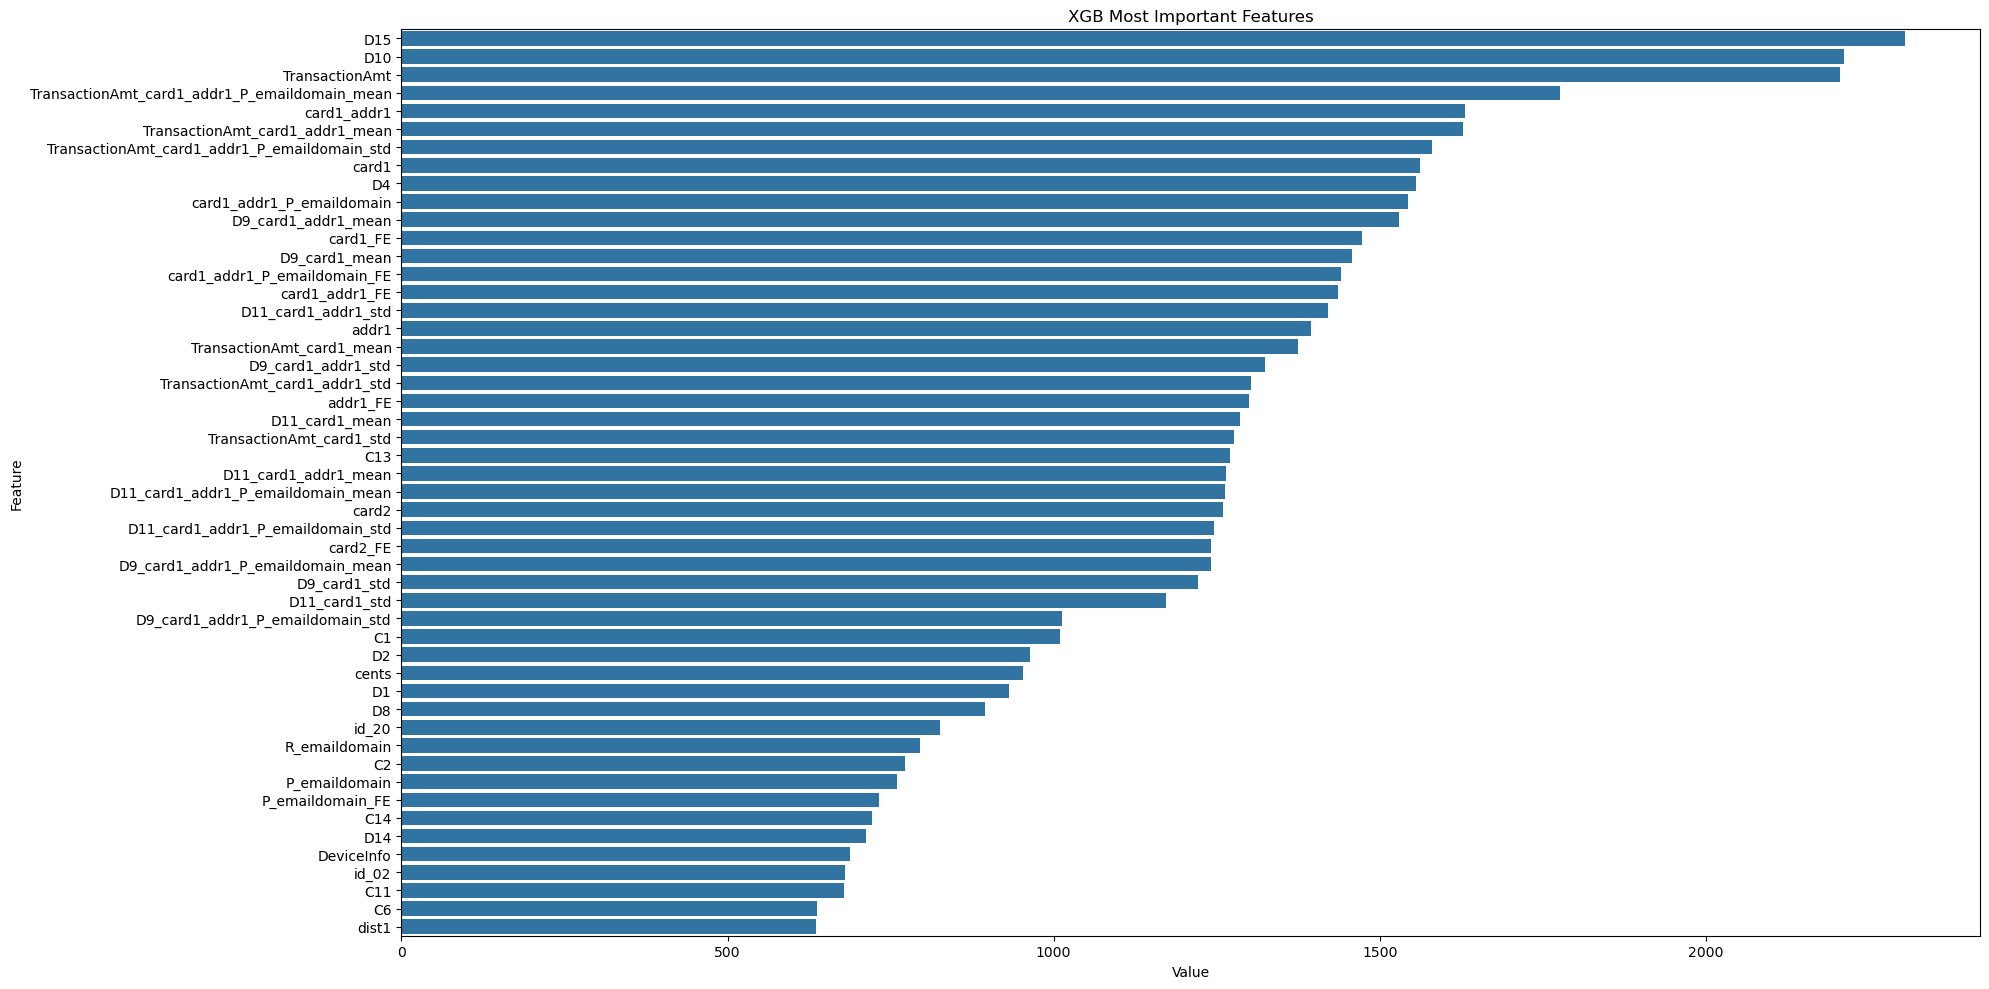

In [14]:
# Create a DataFrame to store feature importances
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,selected_features)), columns=['Value','Feature'])

# Create a figure for the barplot
plt.figure(figsize=(20, 10))

# Create a barplot of the top 50 most important features
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])

# Set the title and adjust layout
plt.title('XGB Most Important Features')
plt.tight_layout()

# Display the plot
plt.show()

# Clean up and free memory
del clf, h; x = gc.collect()

# Predicting test.csv

Upon examining and converting the training data to datetime format, we determined that the starting date is '2017-11-30.' The training data spans from December 2017 to May 2018, corresponding to months 12, 13, 14, 15, 16, and 17. Here, we refer to December 2017 as month 12.

Our objective is to train a model on data from months 13 to 17 and employ this model to predict the test data, which is located further in the future. Consequently, we have a setup called "fold 1," which involves training the model on data from months 13, 14, 15, 16, and 17 while excluding month 12 from the training set. Notably, month 12 serves a specific purpose—it is utilized solely for early stopping during the training process and is not involved in making actual predictions. Importantly, it is not employed for predicting data in the reverse direction.

Ultimately, we will utilize the model trained on data from months 13 to 17 to make predictions on 'test.csv,' which represents data that extends forward in time.

Executing the provided code yields an AUC score of 0.9420 when applying XGBoost for predictions on the test dataset. Nevertheless, due to XGB's significantly slower performance and high computational demands (LGB took 17 minutes, whereas XGB took 16 hours), we have opted to transition to LGB for the remainder of this notebook's testing phase. LGB offers a slightly lower but still outstanding accuracy, registering an AUC score of 0.9399.

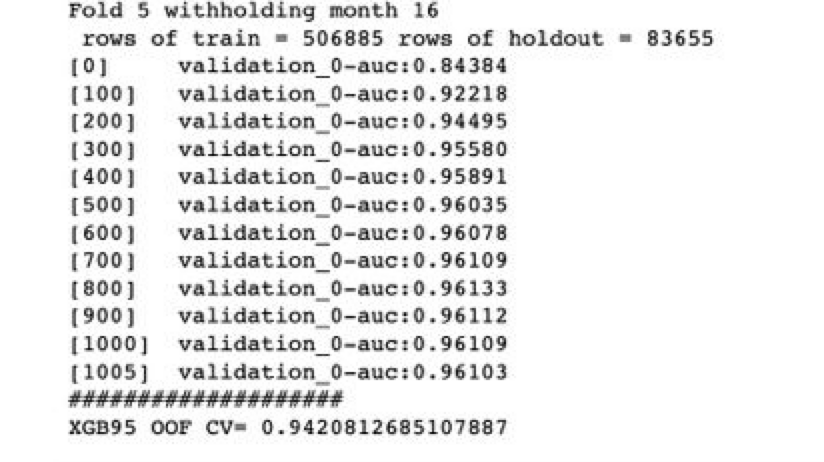

AUC score for XGB model on test dataset

In [15]:
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 
X_train = X_train.copy()

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month 
X_test = X_test.copy()

In [16]:
%%time

# lgboost
# Store out of fold predictions and test set predictions
oof = np.zeros(len(X_train))
preds = np.zeros(len(X_test))

# Setup cross-validation using GroupKFold method
skf = GroupKFold(n_splits=6)
for i, (idxT, idxV) in enumerate(skf.split(X_train, y_train, groups=X_train['DT_M'])):
    month = X_train.iloc[idxV]['DT_M'].iloc[0]
    print('Fold', i, 'withholding month', month)
    print('Rows of train =', len(idxT), 'rows of holdout =', len(idxV))

    # Create the LightGBM classifier
    clf = lgb.LGBMClassifier(
        boosting_type='gbdt',
        n_estimators=5000,
        max_depth=12,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.4,
        metric='auc',
        n_jobs=8
    )

    # Create the log_evaluation callback
    callbacks = [
        lgb.early_stopping(100),
        lgb.callback.log_evaluation(period=100)
    ]

    # Fit the model with callbacks
    h = clf.fit(X_train[selected_features].iloc[idxT], y_train.iloc[idxT],
                eval_set=[(X_train[selected_features].iloc[idxV], y_train.iloc[idxV])],
                callbacks=callbacks)

    best_iteration = clf.best_iteration_  # Get the best iteration
    print("Best Iteration:", best_iteration)

    oof[idxV] += clf.predict_proba(X_train[selected_features].iloc[idxV])[:, 1]
    preds += clf.predict_proba(X_test[selected_features])[:, 1] / skf.n_splits
    del h, clf; x = gc.collect()

print('#' * 30)
print('LGBM out of fold cross validation =', roc_auc_score(y_train, oof))

# xgboost too slow
# %%time
# # Store out of fold predictions and test set predictions
# oof = np.zeros(len(X_train))
# preds = np.zeros(len(X_test))

# # Setup cross-validation using GroupKFold method
# skf = GroupKFold(n_splits=6)
# for i, (idxT, idxV) in enumerate(skf.split(X_train, y_train, groups=X_train['DT_M']) ):
#     month = X_train.iloc[idxV]['DT_M'].iloc[0]
#     print('Fold',i,'withholding month',month)
#     print('Rows of train =',len(idxT),'rows of holdout =',len(idxV))
#     clf = xgb.XGBClassifier(
#         n_estimators=2000, #5000
#         max_depth=12, #12
#         learning_rate=0.02, #0.02
#         subsample=0.8,
#         colsample_bytree=0.4,
#         missing=-1,
#         eval_metric='auc',
#         early_stopping_rounds=100,
#         # USE CPU
#         nthread=4,
#         tree_method='hist'
#         # USE GPU
#         #tree_method='gpu_hist' 
#     )        
#     h = clf.fit(X_train[selected_features].iloc[idxT], y_train.iloc[idxT], 
#             eval_set=[(X_train[selected_features].iloc[idxV],y_train.iloc[idxV])],
#             verbose=100)
    
#     best_iteration = clf.best_iteration  # Get the best iteration
#     print("Best Iteration:", best_iteration)

#     oof[idxV] += clf.predict_proba(X_train[selected_features].iloc[idxV])[:,1]
#     preds += clf.predict_proba(X_test[selected_features])[:,1]/skf.n_splits
#     del h, clf
#     x=gc.collect()
# print('#'*30)
# print ('XGB out of fold cross validation=',roc_auc_score(y_train,oof))

Fold 0 withholding month 12
Rows of train = 453219 rows of holdout = 137321
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.858145
[200]	valid_0's auc: 0.874821
[300]	valid_0's auc: 0.887247
[400]	valid_0's auc: 0.894261
[500]	valid_0's auc: 0.898911
[600]	valid_0's auc: 0.900791
[700]	valid_0's auc: 0.903264
[800]	valid_0's auc: 0.904854
[900]	valid_0's auc: 0.90656
[1000]	valid_0's auc: 0.907997
[1100]	valid_0's auc: 0.909054
[1200]	valid_0's auc: 0.910115
[1300]	valid_0's auc: 0.910854
[1400]	valid_0's auc: 0.911652
[1500]	valid_0's auc: 0.91208
[1600]	valid_0's auc: 0.912616
[1700]	valid_0's auc: 0.913426
[1800]	valid_0's auc: 0.913909
[1900]	valid_0's auc: 0.914592
[2000]	valid_0's auc: 0.915003
[2100]	valid_0's auc: 0.915139
[2200]	valid_0's auc: 0.915583
[2300]	valid_0's auc: 0.915726
[2400]	valid_0's auc: 0.91577
[2500]	valid_0's auc: 0.915801
Early stopping, best iteration is:
[2429]	valid_0's auc: 0.915902
Best Iteration: 2429
Fold 1 withh

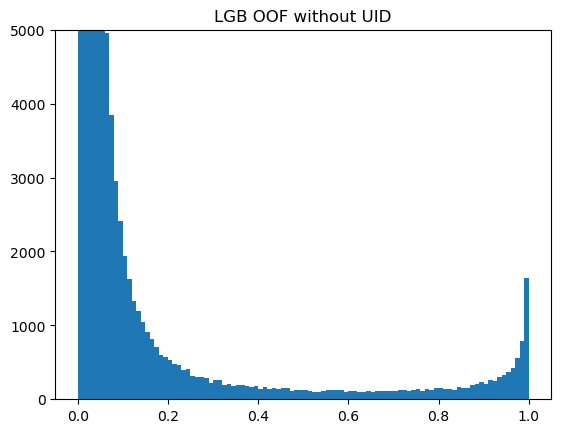

In [17]:
plt.hist(oof,bins=100)
plt.ylim((0,5000))
plt.title('LGB OOF without UID')
plt.show()

# Improvement : Adding of userID(UID) to datasets

Due to the dataset's inherent characteristics, wherein once a client's credit card is associated with fraud, all the transactions within their entire account is categorised as fraud. Thus, this makes it imperative to perform essential preprocessing to identify distinct clients. Failing to do so would lead to inaccurate predictions of fraudulent transactions, as not all transactions flagged as fraud are necessarily fraudulent. Hence, in the following step, to improve our model, we will be creating UID which will allow us to identify clients using the columns card_1, addr_1 and D1.

The UID we've generated isn't flawless, as it includes 3118 UIDs containing both fraudulent and non-fraudulent transactions, which encompasses about 1.4% of all the UIDs generated. This suggests the presence of multiple clients within certain UIDs, though this is a relatively small occurrence within our dataset. However, given that we employ LGB, a tree-based model, it possesses the capability to split and partition its feature space to accommodate this variation. Consequently, our model can effectively separate these UIDs and identify individual clients within them.

Understanding our data: https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203


In [18]:
X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)
X_train = X_train.copy()

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)
X_test = X_test.copy()

In [19]:
# Check for number of UIDs that contain more than one client inside
df = pd.concat([X_train, y_train], axis=1)
x = df.groupby('uid')['isFraud'].apply(lambda x: x.nunique() == 1)
false_entries = x[~x]

print('Total number of UIDs generated:', len(x))
print('Number of UIDs with more than one client inside:', len(false_entries))
print('Percent of bad UIDs:', round(len(false_entries)/len(x),4)*100,'%')

del df,x; x=gc.collect()


Total number of UIDs generated: 217735
Number of UIDs with more than one client inside: 3118
Percent of bad UIDs: 1.43 %


## Group aggregated features

To incorporate the UID into our model, we must generate certain aggregated group features. However, once we've created these aggregated features, we exclude the UID from our model. This is because the UID, much like the transactionID, doesn't contribute to the model's predictive capabilities.

In [20]:
%%time
# FREQUENCY ENCODE UID
encode_FE(X_train,X_test,['uid'])
# AGGREGATE 
encode_AG(['TransactionAmt','D4','D9','D10','D15'],['uid'],['mean','std'],train_df=X_train, test_df=X_test, fillna=True,usena=True)
# AGGREGATE
encode_AG(['C'+str(x) for x in range(1,15) if x!=3],['uid'],['mean'],train_df=X_train, test_df=X_test,fillna=True,usena=True)
# AGGREGATE
encode_AG(['M'+str(x) for x in range(1,10)],['uid'],['mean'],train_df=X_train, test_df=X_test, fillna=True,usena=True)
# AGGREGATE
encode_AG2(['P_emaildomain','dist1','DT_M','id_02','cents'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREGATE
encode_AG(['C14'],['uid'],['std'],train_df=X_train, test_df=X_test,fillna=True,usena=True)
# AGGREGATE 
encode_AG2(['C13','V314'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREGATE 
encode_AG2(['V127','V136','V309','V307','V320'], ['uid'], train_df=X_train, test_df=X_test)
# NEW FEATURE
X_train['outsider15'] = (np.abs(X_train.D1-X_train.D15)>3).astype('int8')
X_test['outsider15'] = (np.abs(X_test.D1-X_test.D15)>3).astype('int8')
print('outsider15')


uid_FE , 'TransactionAmt_uid_mean' , 'TransactionAmt_uid_std' , 'D4_uid_mean' , 'D4_uid_std' , 'D9_uid_mean' , 'D9_uid_std' , 'D10_uid_mean' , 'D10_uid_std' , 'D15_uid_mean' , 'D15_uid_std' , 'C1_uid_mean' , 'C2_uid_mean' , 'C4_uid_mean' , 'C5_uid_mean' , 'C6_uid_mean' , 'C7_uid_mean' , 'C8_uid_mean' , 'C9_uid_mean' , 'C10_uid_mean' , 'C11_uid_mean' , 'C12_uid_mean' , 'C13_uid_mean' , 'C14_uid_mean' , 'M1_uid_mean' , 'M2_uid_mean' , 'M3_uid_mean' , 'M4_uid_mean' , 'M5_uid_mean' , 'M6_uid_mean' , 'M7_uid_mean' , 'M8_uid_mean' , 'M9_uid_mean' , uid_P_emaildomain_ct, uid_dist1_ct, uid_DT_M_ct, uid_id_02_ct, uid_cents_ct, 'C14_uid_std' , uid_C13_ct, uid_V314_ct, uid_V127_ct, uid_V136_ct, uid_V309_ct, uid_V307_ct, uid_V320_ct, outsider15
CPU times: user 43.7 s, sys: 3.65 s, total: 47.3 s
Wall time: 48.9 s


## Feature selection

We perform feature selection again on the dataset as we did before.

In [21]:
# Define the start and end timestamps for the first and last months, assuming 30 days in a month
start_timestamp_first_month = X_train['TransactionDT'].min()
end_timestamp_first_month = start_timestamp_first_month + (30 * 24 * 60 * 60)  

start_timestamp_last_month = X_train['TransactionDT'].max() - (30 * 24 * 60 * 60)  
end_timestamp_last_month = X_train['TransactionDT'].max()

# Select rows corresponding to the first month
X_first_month = X_train[(X_train['TransactionDT'] >= start_timestamp_first_month) &
                         (X_train['TransactionDT'] < end_timestamp_first_month)]

# Select rows corresponding to the last month
X_last_month = X_train[(X_train['TransactionDT'] >= start_timestamp_last_month) &
                        (X_train['TransactionDT'] <= end_timestamp_last_month)]

# Extract the indices of rows in X_train that belong to the first month
indices_first_month = (X_train['TransactionDT'] >= start_timestamp_first_month) & (X_train['TransactionDT'] < end_timestamp_first_month)

# Extract the indices of rows in X_train that belong to the last month
indices_last_month = (X_train['TransactionDT'] >= start_timestamp_last_month) & (X_train['TransactionDT'] <= end_timestamp_last_month)

# Use the indices to extract the corresponding y_train entries
y_first_month = y_train[indices_first_month]
y_last_month = y_train[indices_last_month]

In [22]:
%%time
# Create an empty list to store the selected features
selected_features = []

# Define the evaluation threshold (AUC > 0.5)
threshold = 0.5
X_train = X_train.drop('uid', axis=1)

# Create a tqdm progress bar for the loop
for feature in tqdm(X_train.columns, desc="Processing Features"):
    
    # Train a logistic regression model using only the current feature
    #model = xgb.XGBClassifier()
    model = lgb.LGBMClassifier()
    model.fit(X_first_month[[feature]], y_first_month)
    
    # Predict on the last month of the training data
    y_pred = model.predict_proba(X_last_month[[feature]])[:, 1]
    
    # Calculate AUC for the validation set
    auc = roc_auc_score(y_last_month, y_pred)
    
    # Check if AUC is above the threshold
    if auc > threshold:
        selected_features.append(feature)

Processing Features: 100%|████████████████████| 290/290 [01:27<00:00,  3.30it/s]

CPU times: user 9min 3s, sys: 1min 40s, total: 10min 44s
Wall time: 1min 28s


In [23]:
print('Following',290 - len(selected_features),'features removed:')
print(np.array(set(X_train.columns) - set(selected_features)))
print('#'*70)
print('Following',len(selected_features),'features selected:')
print(np.array(selected_features))


Following 39 features removed:
{'V68', 'V310', 'V107', 'V65', 'V26', 'V297', 'V89', 'day', 'id_22', 'V88', 'V142', 'V56', 'V305', 'V160', 'id_26', 'V67', 'outsider15', 'id_34', 'V314', 'id_08', 'V309', 'id_38', 'id_31', 'V14', 'DT_M', 'V27', 'V285', 'id_32', 'V138', 'id_21', 'TransactionDT', 'V162', 'V20', 'V289', 'card4', 'V62', 'id_14', 'id_07', 'V286'}
######################################################################
Following 251 features selected:
['TransactionAmt' 'ProductCD' 'card1' 'card2' 'card3' 'card5' 'card6'
 'addr1' 'addr2' 'dist1' 'dist2' 'P_emaildomain' 'R_emaildomain' 'C1' 'C2'
 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'C9' 'C10' 'C11' 'C12' 'C13' 'C14' 'D1'
 'D2' 'D3' 'D4' 'D5' 'D6' 'D7' 'D8' 'D9' 'D10' 'D11' 'D12' 'D13' 'D14'
 'D15' 'M1' 'M2' 'M3' 'M4' 'M5' 'M6' 'M7' 'M8' 'M9' 'V1' 'V3' 'V4' 'V6'
 'V8' 'V11' 'V13' 'V17' 'V23' 'V30' 'V36' 'V37' 'V40' 'V41' 'V44' 'V47'
 'V48' 'V54' 'V59' 'V70' 'V76' 'V78' 'V80' 'V82' 'V86' 'V91' 'V108' 'V111'
 'V115' 'V117' 'V120' 'V121' 'V1

## Local validation 

Once again, we perform local validation as in the code above. 

We use train test split by training on first 75% of the train data and predicting 25% of the train data.  Due to XGB's significantly slower performance and high computational demands (LGB took 17 minutes, whereas XGB took 16 hours), we have opted to transition to LGB for the remainder of this notebook's testing phase.

When we run the code below using XGB, we are able to obtain a AUC of 0.9557 on the test set, which is better than the AUC of XGB without using UID, which is 0.9420.

LGB achieved an impressive accuracy of 0.9549, surpassing the accuracy of LGB without UID which is 0.9399. LGB with UID only falls short of XGB with UID by 0.0008 AUC score, but it compensates by running approximately 60 times faster, which is essential for testing purposes.

Catboost was also able to obtain a respectable accuracy of 0.9517.

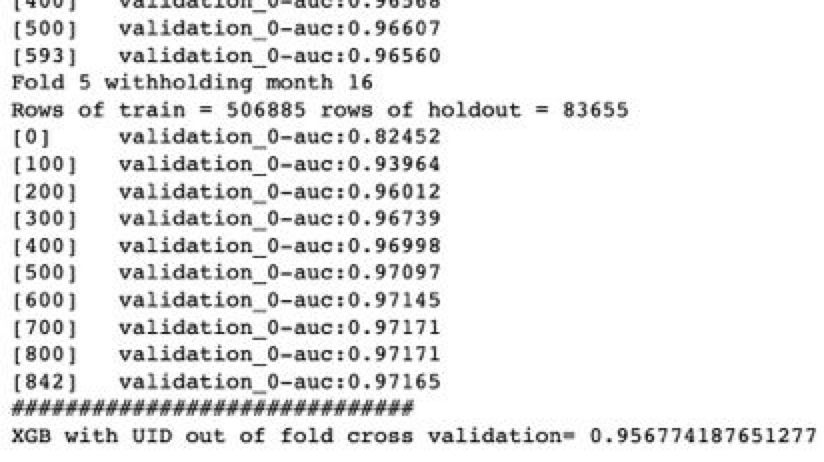

AUC score for XGB model with UID

In [24]:
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

In [25]:
%%time

# lgboost
print("LGBoost version:", lgb.__version__)

clf = lgb.LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=5000,
    max_depth=12,
    learning_rate=0.02,
    subsample=0.8,
    colsample_bytree=0.4,
    metric='auc',
    n_jobs=8
)

# Create the log_evaluation callback
callbacks = [
    lgb.early_stopping(100),
    lgb.callback.log_evaluation(period=100)  # Add this callback for verbosity
]

# Fit the model with callbacks
h = clf.fit(
    X_train.loc[idxT, selected_features],
    y_train[idxT],
    eval_set=[(X_train.loc[idxV, selected_features], y_train[idxV])],
    callbacks=callbacks  # Use the callbacks argument for controlling verbosity
)

# xgboost too slow
#
# clf = xgb.XGBClassifier( 
#     n_estimators=2000,
#     max_depth=12, 
#     learning_rate=0.02, 
#     subsample=0.8,
#     colsample_bytree=0.4, 
#     missing=-1, 
#     eval_metric='auc',
#     early_stopping_rounds=100,
#     nthread=-1,
#     tree_method='hist' 
#     #tree_method='gpu_hist' 
# )
# h = clf.fit(X_train.loc[idxT,selected_features], y_train[idxT], 
#     eval_set=[(X_train.loc[idxV,selected_features],y_train[idxV])],
#     verbose=50)

# best_iteration = clf.best_iteration  # Get the best iteration
# print("Best Iteration:", best_iteration)

LGBoost version: 3.3.5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.890824
[200]	valid_0's auc: 0.911559
[300]	valid_0's auc: 0.92016
[400]	valid_0's auc: 0.926171
[500]	valid_0's auc: 0.930124
[600]	valid_0's auc: 0.932434
[700]	valid_0's auc: 0.933558
[800]	valid_0's auc: 0.934692
[900]	valid_0's auc: 0.935379
[1000]	valid_0's auc: 0.936157
[1100]	valid_0's auc: 0.937174
[1200]	valid_0's auc: 0.937814
[1300]	valid_0's auc: 0.938028
[1400]	valid_0's auc: 0.938484
[1500]	valid_0's auc: 0.938631
[1600]	valid_0's auc: 0.939212
[1700]	valid_0's auc: 0.93986
[1800]	valid_0's auc: 0.940159
[1900]	valid_0's auc: 0.94069
[2000]	valid_0's auc: 0.940737
[2100]	valid_0's auc: 0.940879
[2200]	valid_0's auc: 0.940918
[2300]	valid_0's auc: 0.941185
[2400]	valid_0's auc: 0.941453
[2500]	valid_0's auc: 0.941378
[2600]	valid_0's auc: 0.94153
[2700]	valid_0's auc: 0.941556
[2800]	valid_0's auc: 0.941768
[2900]	valid_0's auc: 0.94187
Early stopping, best iteration

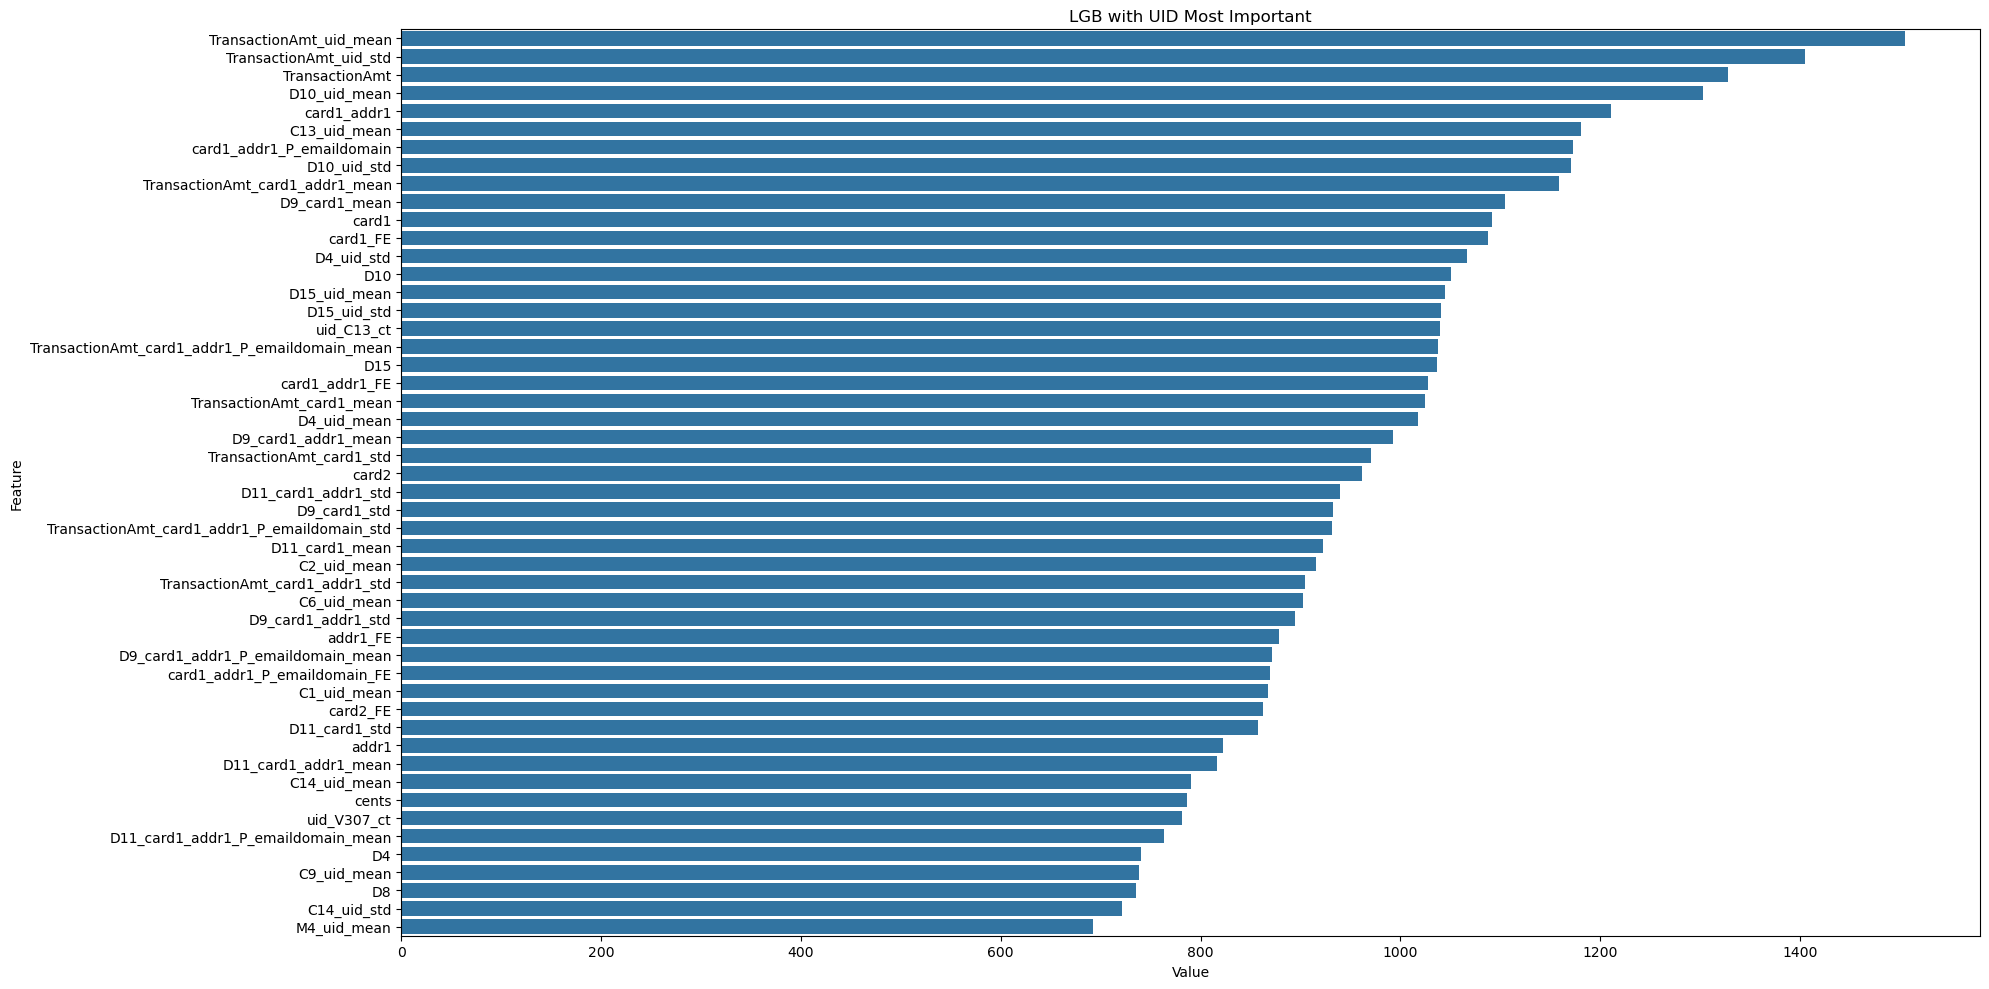

In [26]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,selected_features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('LGB with UID Most Important')
plt.tight_layout()
plt.show()

## Predicting test.csv with UID aggregated colums included


In [27]:
%%time

# lgboost
# Store out of fold predictions and test set predictions
lgb_oof = np.zeros(len(X_train))
lgb_preds = np.zeros(len(X_test))

# Setup cross-validation using GroupKFold method
skf = GroupKFold(n_splits=6)
for i, (idxT, idxV) in enumerate(skf.split(X_train, y_train, groups=X_train['DT_M'])):
    month = X_train.iloc[idxV]['DT_M'].iloc[0]
    print('Fold', i, 'withholding month', month)
    print('Rows of train =', len(idxT), 'rows of holdout =', len(idxV))

    # Create the LightGBM classifier
    clf = lgb.LGBMClassifier(
        boosting_type='gbdt',
        n_estimators=5000,
        max_depth=12,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.4,
        metric='auc',
        n_jobs=8
    )

    # Create the log_evaluation callback
    callbacks = [
        lgb.early_stopping(100),
        lgb.callback.log_evaluation(period=100)
    ]

    # Fit the model with callbacks
    h = clf.fit(X_train[selected_features].iloc[idxT], y_train.iloc[idxT],
                eval_set=[(X_train[selected_features].iloc[idxV], y_train.iloc[idxV])],
                callbacks=callbacks)

    best_iteration = clf.best_iteration_  # Get the best iteration
    print("Best Iteration:", best_iteration)

    lgb_oof[idxV] += clf.predict_proba(X_train[selected_features].iloc[idxV])[:, 1]
    lgb_preds += clf.predict_proba(X_test[selected_features])[:, 1] / skf.n_splits
    del h, clf; x = gc.collect()

print('#' * 30)
print('LGBM with UID out of fold cross validation =', roc_auc_score(y_train, lgb_oof))


Fold 0 withholding month 12
Rows of train = 453219 rows of holdout = 137321
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.87846
[200]	valid_0's auc: 0.893762
[300]	valid_0's auc: 0.904864
[400]	valid_0's auc: 0.910819
[500]	valid_0's auc: 0.914855
[600]	valid_0's auc: 0.917971
[700]	valid_0's auc: 0.920434
[800]	valid_0's auc: 0.922549
[900]	valid_0's auc: 0.923751
[1000]	valid_0's auc: 0.924891
[1100]	valid_0's auc: 0.925889
[1200]	valid_0's auc: 0.926938
[1300]	valid_0's auc: 0.927761
[1400]	valid_0's auc: 0.928447
[1500]	valid_0's auc: 0.928798
[1600]	valid_0's auc: 0.929598
[1700]	valid_0's auc: 0.929921
[1800]	valid_0's auc: 0.93036
[1900]	valid_0's auc: 0.9305
[2000]	valid_0's auc: 0.930532
[2100]	valid_0's auc: 0.930688
[2200]	valid_0's auc: 0.931026
[2300]	valid_0's auc: 0.931204
[2400]	valid_0's auc: 0.931205
[2500]	valid_0's auc: 0.931346
[2600]	valid_0's auc: 0.931693
[2700]	valid_0's auc: 0.931642
Early stopping, best iteration is:
[26

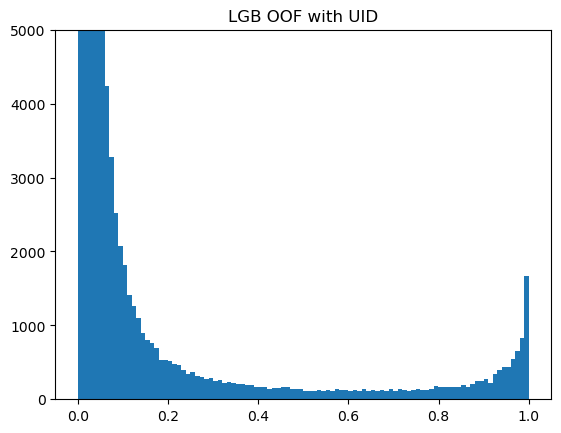

In [28]:
plt.hist(lgb_oof,bins=100)
plt.ylim((0,5000))
plt.title('LGB OOF with UID')
plt.show()

## Further improvements: Model stacking

To enhance our model's performance, we have adopted ensemble learning, a technique where we combine LGB, CatBoost, and XGBoost models into a unified ensemble. Each of these models has been evaluated individually using the cross-validation using GroupKFold method, yielding the following AUC scores:

1. LGB: 0.9549
2. CatBoost: 0.9517
3. XGBoost: 0.9557

Our goal is to leverage the strengths of these individual models by combining them strategically. To achieve this, we've implemented a weighted ensemble approach. In this approach, we assign varying weightage to each model based on their respective AUC scores. The aim is to prioritize the more accurate models, ensuring they have a more substantial influence on the final predictions.

As a result of this ensemble weighting strategy, our ensemble model has experienced a notable improvement in AUC, achieving a score of 0.9578.

In [29]:
%%time

# Store out of fold predictions and test set predictions
cat_oof = np.zeros(len(X_train))
cat_preds = np.zeros(len(X_test))

# Setup cross-validation using GroupKFold method
skf = GroupKFold(n_splits=6)
for i, (idxT, idxV) in enumerate(skf.split(X_train, y_train, groups=X_train['DT_M'])):
    month = X_train.iloc[idxV]['DT_M'].iloc[0]
    print('Fold', i, 'withholding month', month)
    print('Rows of train =', len(idxT), 'rows of holdout =', len(idxV))

    # Create the CatBoost classifier
    clf = cb.CatBoostClassifier(
        iterations=5000,
        depth=12,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bylevel=0.4,
        eval_metric='AUC',
        early_stopping_rounds=100,
        verbose=100
    )

    # Prepare the data using the Pool object
    train_pool = Pool(
        X_train[selected_features].iloc[idxT],
        label=y_train.iloc[idxT]
    )

    val_pool = Pool(
        X_train[selected_features].iloc[idxV],
        label=y_train.iloc[idxV]
    )

    # Fit the CatBoost model
    h = clf.fit(
        train_pool,
        eval_set=val_pool
    )

    best_iteration = clf.best_iteration_  # Get the best iteration
    print("Best Iteration:", best_iteration)

    cat_oof[idxV] += clf.predict_proba(X_train[selected_features].iloc[idxV])[:, 1]
    cat_preds += clf.predict_proba(X_test[selected_features])[:, 1] / skf.n_splits
    del h, clf; x=gc.collect()

print('#' * 30)
print('CatBoost with UID out of fold cross-validation =', roc_auc_score(y_train, cat_oof))


Fold 0 withholding month 12
Rows of train = 453219 rows of holdout = 137321
0:	test: 0.6621260	best: 0.6621260 (0)	total: 413ms	remaining: 34m 26s
100:	test: 0.8674386	best: 0.8674386 (100)	total: 34.8s	remaining: 28m 9s
200:	test: 0.8977459	best: 0.8977459 (200)	total: 1m 8s	remaining: 27m 21s
300:	test: 0.9099566	best: 0.9099566 (300)	total: 1m 43s	remaining: 26m 51s
400:	test: 0.9158948	best: 0.9158983 (399)	total: 2m 17s	remaining: 26m 21s
500:	test: 0.9201498	best: 0.9201498 (500)	total: 2m 52s	remaining: 25m 51s
600:	test: 0.9230600	best: 0.9230600 (600)	total: 3m 27s	remaining: 25m 20s
700:	test: 0.9252622	best: 0.9252825 (699)	total: 4m 2s	remaining: 24m 46s
800:	test: 0.9271570	best: 0.9271867 (794)	total: 4m 37s	remaining: 24m 12s
900:	test: 0.9282982	best: 0.9282982 (900)	total: 5m 12s	remaining: 23m 39s
1000:	test: 0.9291519	best: 0.9291519 (1000)	total: 5m 46s	remaining: 23m 6s
1100:	test: 0.9299204	best: 0.9299277 (1098)	total: 6m 21s	remaining: 22m 32s
1200:	test: 0.9306

700:	test: 0.9584163	best: 0.9584163 (700)	total: 4m 18s	remaining: 26m 27s
800:	test: 0.9597821	best: 0.9597821 (800)	total: 4m 55s	remaining: 25m 49s
900:	test: 0.9612868	best: 0.9612868 (900)	total: 5m 32s	remaining: 25m 12s
1000:	test: 0.9619952	best: 0.9619952 (1000)	total: 6m 9s	remaining: 24m 34s
1100:	test: 0.9628602	best: 0.9628602 (1100)	total: 6m 46s	remaining: 23m 58s
1200:	test: 0.9632340	best: 0.9632438 (1184)	total: 7m 22s	remaining: 23m 21s
1300:	test: 0.9638077	best: 0.9638099 (1299)	total: 7m 59s	remaining: 22m 43s
1400:	test: 0.9638946	best: 0.9639522 (1369)	total: 8m 36s	remaining: 22m 7s
1500:	test: 0.9642418	best: 0.9642418 (1500)	total: 9m 13s	remaining: 21m 30s
1600:	test: 0.9644647	best: 0.9644929 (1549)	total: 9m 50s	remaining: 20m 52s
1700:	test: 0.9644793	best: 0.9645538 (1685)	total: 10m 26s	remaining: 20m 15s
1800:	test: 0.9645485	best: 0.9645904 (1786)	total: 11m 3s	remaining: 19m 38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.96

In [30]:
%%time 

# xgboost too slow
# Store out of fold predictions and test set predictions
xgb_oof = np.zeros(len(X_train))
xgb_preds = np.zeros(len(X_test))

# Setup cross-validation using GroupKFold method
skf = GroupKFold(n_splits=6)
for i, (idxT, idxV) in enumerate(skf.split(X_train, y_train, groups=X_train['DT_M']) ):
    month = X_train.iloc[idxV]['DT_M'].iloc[0]
    print('Fold',i,'withholding month',month)
    print('Rows of train =',len(idxT),'rows of holdout =',len(idxV))
    clf = xgb.XGBClassifier(
        n_estimators=1000, #5000
        max_depth=12, #12
        learning_rate=0.02, #0.02
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1,
        eval_metric='auc',
        early_stopping_rounds=100,
        # USE CPU
        nthread=-1,
        tree_method='hist'
        # USE GPU
        #tree_method='gpu_hist' 
    )        
    h = clf.fit(X_train[selected_features].iloc[idxT], y_train.iloc[idxT], 
            eval_set=[(X_train[selected_features].iloc[idxV],y_train.iloc[idxV])],
            verbose=50)
    
    best_iteration = clf.best_iteration  # Get the best iteration
    print("Best Iteration:", best_iteration)

    xgb_oof[idxV] += clf.predict_proba(X_train[selected_features].iloc[idxV])[:,1]
    xgb_preds += clf.predict_proba(X_test[selected_features])[:,1]/skf.n_splits
    del h, clf; x=gc.collect()
print('#'*30)
print ('XGB with UID out of fold cross validation=',roc_auc_score(y_train,xgb_oof))

Fold 0 withholding month 12
Rows of train = 453219 rows of holdout = 137321
[0]	validation_0-auc:0.81230
[50]	validation_0-auc:0.88061
[100]	validation_0-auc:0.89615
[150]	validation_0-auc:0.90671
[200]	validation_0-auc:0.91490
[250]	validation_0-auc:0.91800
[300]	validation_0-auc:0.92058
[350]	validation_0-auc:0.92256
[400]	validation_0-auc:0.92391
[450]	validation_0-auc:0.92477
[500]	validation_0-auc:0.92557
[550]	validation_0-auc:0.92593
[600]	validation_0-auc:0.92621
[650]	validation_0-auc:0.92615
[700]	validation_0-auc:0.92633
[750]	validation_0-auc:0.92657
[800]	validation_0-auc:0.92646
[850]	validation_0-auc:0.92644
[886]	validation_0-auc:0.92627
Best Iteration: 787
Fold 1 withholding month 15
Rows of train = 488908 rows of holdout = 101632
[0]	validation_0-auc:0.83969
[50]	validation_0-auc:0.90667
[100]	validation_0-auc:0.92435
[150]	validation_0-auc:0.93863
[200]	validation_0-auc:0.94858
[250]	validation_0-auc:0.95388
[300]	validation_0-auc:0.95750
[350]	validation_0-auc:0.959

In [59]:
# Stacking models together

lgb_auc = roc_auc_score(y_train, lgb_oof)
cat_auc = roc_auc_score(y_train, cat_oof)
xgb_auc = roc_auc_score(y_train, xgb_oof)

print('CatBoost with UID out of fold cross-validation =', cat_auc)
print('LGBM with UID out of fold cross validation =', lgb_auc)
print('XGB with UID out of fold cross validation =', xgb_auc)

# Initialize array to store ensemble predictions
ensemble_valid_preds = np.zeros(len(lgb_oof))

# Define weights for each model's predictions
weight_xgb = xgb_auc/(lgb_auc + cat_auc + xgb_auc)
weight_lightgbm = lgb_auc/(lgb_auc + cat_auc + xgb_auc)
weight_catboost = cat_auc/(lgb_auc + cat_auc + xgb_auc)

# Add weighted predictions from XGBoost
ensemble_valid_preds += weight_catboost * xgb_oof

# Add weighted predictions from LightGBM
ensemble_valid_preds += weight_lightgbm * lgb_oof

# Add weighted predictions from CatBoost
ensemble_valid_preds += weight_catboost * cat_oof

ensemble_roc_auc = roc_auc_score(y_train, ensemble_valid_preds)
print('Ensemble ROC AUC Score:', ensemble_roc_auc)

CatBoost with UID out of fold cross-validation = 0.9517459481319461
LGBM with UID out of fold cross validation = 0.9548717473927644
XGB with UID out of fold cross validation = 0.955664486621167
Ensemble ROC AUC Score: 0.9578369712110505


In [37]:
# Combine the OOF predictions from LightGBM and CatBoost into a single dataset
combined_oof = np.column_stack((lgb_oof, cat_oof, xgb_oof))

# Initialize the logistic regression model
logreg_model = LogisticRegression()

# Train the logistic regression model using the combined OOF predictions
logreg_model.fit(combined_oof, y_train)  # Assuming y_valid contains the true labels

# Use the trained logistic regression model to make ensemble predictions on the validation set
ensemble_valid_preds = logreg_model.predict_proba(combined_oof)[:, 1]

# Calculate ROC AUC score for the ensemble predictions
ensemble_roc_auc = roc_auc_score(y_train, ensemble_valid_preds)
print('Ensemble ROC AUC Score:', ensemble_roc_auc)


Ensemble ROC AUC Score: 0.9566276316426746


In [33]:
# SUSSS

# Combine the OOF predictions from LightGBM and CatBoost into a single dataset
combined_oof = np.column_stack((lgb_oof, cat_oof))

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust hyperparameters
rf_model.fit(combined_oof, y_train)  # Assuming y_train contains the true labels

# Use the trained Random Forest model to make ensemble predictions on the validation set
ensemble_valid_preds = rf_model.predict_proba(combined_oof)[:, 1]

# Calculate ROC AUC score for the ensemble predictions
ensemble_roc_auc = roc_auc_score(y_train, ensemble_valid_preds)
print('Ensemble ROC AUC Score:', ensemble_roc_auc)


Ensemble ROC AUC Score: 0.9999998665434541
